# Evaluate MPAS and FV3 ensembles
- compare severe weather surrogates and SPC storm reports
- May 2023 and 2024 Hazardous Weather Testbeds (HWT2023 and HWT2024)

### Import modules
- [contingency_table.py](contingency_table.py) and [hwt2024.py](hwt2024.py) are custom modules
- put in current directory

In [1]:
import logging
import os
import pdb
from multiprocessing import Pool
from pathlib import Path

import pandas as pd
import seaborn as sns
import xarray
from scipy.ndimage import maximum_filter
from tqdm import tqdm

# First put contingency_table.py and hwt2024.py in current directory.
from contingency_table import accuracy, bias, csi, ets, far, hk, hss, pod, pofd, total
from hwt2024 import Model, firstRun, helicityThresholds, windThresholds

sns.set_theme()  # nice background on plots
logging.basicConfig(level=logging.WARNING, format="%(asctime)s %(message)s", force=True)
tmpdir = Path(os.getenv("TMPDIR"))

### Define `group`, `thresholds`, `genericnames`, `models`, `conus_mask`, `rpt_types`, and `counts`

In [2]:
group = "wind"
thresholds = helicityThresholds if group == "uh" else windThresholds
genericnames = (
    ["0-1km UH", "0-3km UH", "2-5km UH"] if group == "uh" else ["updraft max", "10m speed max"]
)


fv3 = Model(
    "fv3",
    nmem=10,
    v=["MXUPHL0_1km_max", "MXUPHL0_3km_max", "MXUPHL2_5km_max"]
    if group == "uh"
    else ["MAXUVV_max", "MAXWIND10m"],
    lead_time_days=8,
)
mpas = Model(
    "mpas",
    nmem=5,
    v=["updraft_helicity_max01", "updraft_helicity_max03", "updraft_helicity_max"]
    if group == "uh"
    else ["w_velocity_max", "wind_speed_10m_max"],
    lead_time_days=5,
)
models = [fv3, mpas]
# assert models all have same number of variables
nvars = len(genericnames)
assert all(
    [len(model.v) == nvars for model in models]
), "Model objects have different number of variables to analyze"

conus_mask = xarray.open_dataarray(
    Path(os.getenv("HOME").replace(os.getenv("USER"), "ahijevyc")) / "HWT_2024.conus.nc"
)

rpt_types = ["torn", "wind", "hail"]
counts = ["hits", "misses", "false alarms", "correct nulls"]

### Illustrate filter that will be applied to forecast

Text(0.5, 1.0, 'after')

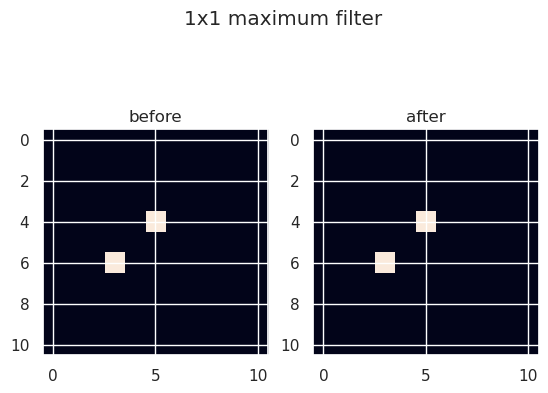

In [3]:
filter_size = 1
import matplotlib.pyplot as plt
import numpy as np

a = np.zeros((11, 11))  # all zero, square matrix
a[6, 3] = 1  # except two points are equal to one
a[4, 5] = 1
fig, axes = plt.subplots(ncols=2)
fig.suptitle(f"{filter_size}x{filter_size} maximum filter")
axes[0].imshow(a)
axes[0].set_title("before")
a = maximum_filter(a, filter_size)
axes[1].imshow(a)
axes[1].set_title("after")

In [4]:
def ct_and_mse(ds, valid_date, model, climo=None):
    """
    Match forecast and observations
    for one valid date and model.
    Calculate hits, misses, false alarms, and correct nulls.
    Return contingency table (ct) and Brier score (mean squared error; mse).
    """

    rptfile = datadir / f"near_rpt.{valid_date.strftime('%Y-%m-%d %H:%M:%S')}.nc"
    logging.info(f"open existing {rptfile}")
    near_rpts = xarray.open_dataarray(rptfile)
    # Keep near_rpts where conus_mask is True; otherwise set to nan.
    # nans will propagate to h, m, f, and n and not be counted when the .sum() function
    # is used below.
    near_rpts = near_rpts.where(conus_mask)

    fy = ds.ensmax
    h = fy * (near_rpts == 1)
    m = ~fy * (near_rpts == 1)
    f = fy * (near_rpts == 0)
    n = ~fy * (near_rpts == 0)
    hmfn = (
        xarray.concat([h, m, f, n], dim="count")
        .sum(dim=["lon", "lat"])
        .assign_coords(count=counts, valid_date=valid_date, model=model)
        .expand_dims(["valid_date", "model"])
    )

    hmfn.name = fy.name
    hmfn.attrs = ds.attrs

    if climo is None:
        # If climo is not provided use mean event frequency on this valid_date.
        climo = (hmfn.sel(count="hits") + hmfn.sel(count="misses")) / total(hmfn)
        climo = climo.mean(dim=["lon", "lat"])

    brierScoreClimo = (climo - near_rpts) ** 2
    brierScoreClimo.name = "brierScoreClimo"

    brierScore = (ds.enssum / ds.attrs["nmem"] - near_rpts) ** 2
    brierScore.name = "brierScore"

    brierScore = xarray.merge([brierScore, brierScoreClimo])
    brierScore = (
        brierScore.mean(dim=["lon", "lat"])
        .assign_coords(valid_date=valid_date, model=model)
        .expand_dims(["valid_date", "model"])
    )
    assert brierScore.max() < 1, f"bad brierScore in {valid_date} {model} {brierScore.max()}"
    brierScore.attrs = ds.attrs

    print(f"{valid_date} {model}", end=" ")
    return hmfn, brierScore


def run_ct(valid_date, model, filter_size):
    """
    Apply a filter_size maximum filter to forecast
    before sending forecast to ct_and_mse method.
    """
    idir = Path(f"/glade/campaign/mmm/parc/schwartz/HWT2024/{model}")
    ncfile = datadir / f"forecast_yes.{model}.{group}.{valid_date.strftime('%Y%m%d')}.nc"
    logging.info(f"open existing {ncfile}")
    fy = xarray.open_dataset(ncfile)
    fy.encoding["source"] = ncfile
    # Assign generic variable names instead of model-dependent names.
    fy = fy.assign_coords({"variable": genericnames})

    for v in ["ensmax", "enssum"]:
        assert not fy[v].isnull().any(), f"{fy[v].isnull().sum()} null in {v}"

    varname = "ensmax"
    logging.info(f"Apply {filter_size}x{filter_size} filter to {varname}")
    v = fy[varname]
    londim = v.dims.index("lon")
    latdim = v.dims.index("lat")
    fy[varname][:] = maximum_filter(v, size=filter_size, axes=(londim, latdim))
    fy[varname].attrs["filter_size"] = filter_size
    # Use climatological frequency of "torn" "wind" "hail" as reference forecast
    # when calculating the Brier Skill Score.
    climo = xarray.DataArray(
        [0.00394758, 0.01859965, 0.01432699], coords={"rpt_type": rpt_types}
    )

    return ct_and_mse(fy, valid_date, model, climo=climo)

## Get contingency table and Brier Score for all valid dates.
- First time this is executed, calculate the table and Brier Score for each date
    - This takes hours unless multiprocessing is used.
    - Process multiple valid dates in parallel.
    - Reserve enough memory beforehand--more jobs in parallel require more memory.
    - Save data to disk.
- Subsequent times, it will read the data from disk.

In [5]:
# Replace USER with "ahijevyc". So it points to his TMPDIR, not others'.
datadir = Path(os.getenv("TMPDIR").replace(os.getenv("USER"), "ahijevyc"))
sfx = f".2023-2024.{group}{len(genericnames)}.{len(thresholds)}.{filter_size}x{filter_size}.nc"
ofile = datadir / f"hmfn{sfx}"
ofile2 = datadir / f"brierScore{sfx}"
if os.path.exists(ofile) and os.path.exists(ofile2):
    logging.warning(f"open {ofile} and {ofile2}")
    contingency_table = xarray.open_dataarray(ofile)
    brierScore = xarray.open_dataset(ofile2)
else:
    d2023 = pd.date_range(start=firstRun(2023), end="20230531", freq="1D")
    d2024 = pd.date_range(start=firstRun(2024), end="20240531", freq="1D")
    valid_dates = d2023.union(d2024)

    with Pool(processes=16) as pool:
        results = pool.starmap(
            run_ct,
            [
                (valid_date, str(model), filter_size)
                for model in models
                for valid_date in valid_dates
            ],
        )

    hmfn, brierScore = zip(*results)

    contingency_table = xarray.combine_by_coords(
        hmfn,
        combine_attrs="drop_conflicts",
    ).ensmax

    contingency_table.to_netcdf(ofile)
    logging.warning(ofile)
    bs = xarray.combine_by_coords(
        brierScore,
        combine_attrs="drop_conflicts",
    )

    bs.to_netcdf(ofile2)
    logging.warning(ofile2)

2024-08-13 15:57:21,943 open /glade/derecho/scratch/ahijevyc/tmp/hmfn.2023-2024.wind2.10.1x1.nc and /glade/derecho/scratch/ahijevyc/tmp/brierScore.2023-2024.wind2.10.1x1.nc


## Plot results
For example, equitable threat score (ets), bias, Heidke Skill Score (hss), false alarm ratio
### Ways to stratify results
- model
- dayForecast
- valid_date
- threshold
- variable
- rpt_type

2024-08-13 15:58:08,348 results.updraft max.1x1.png


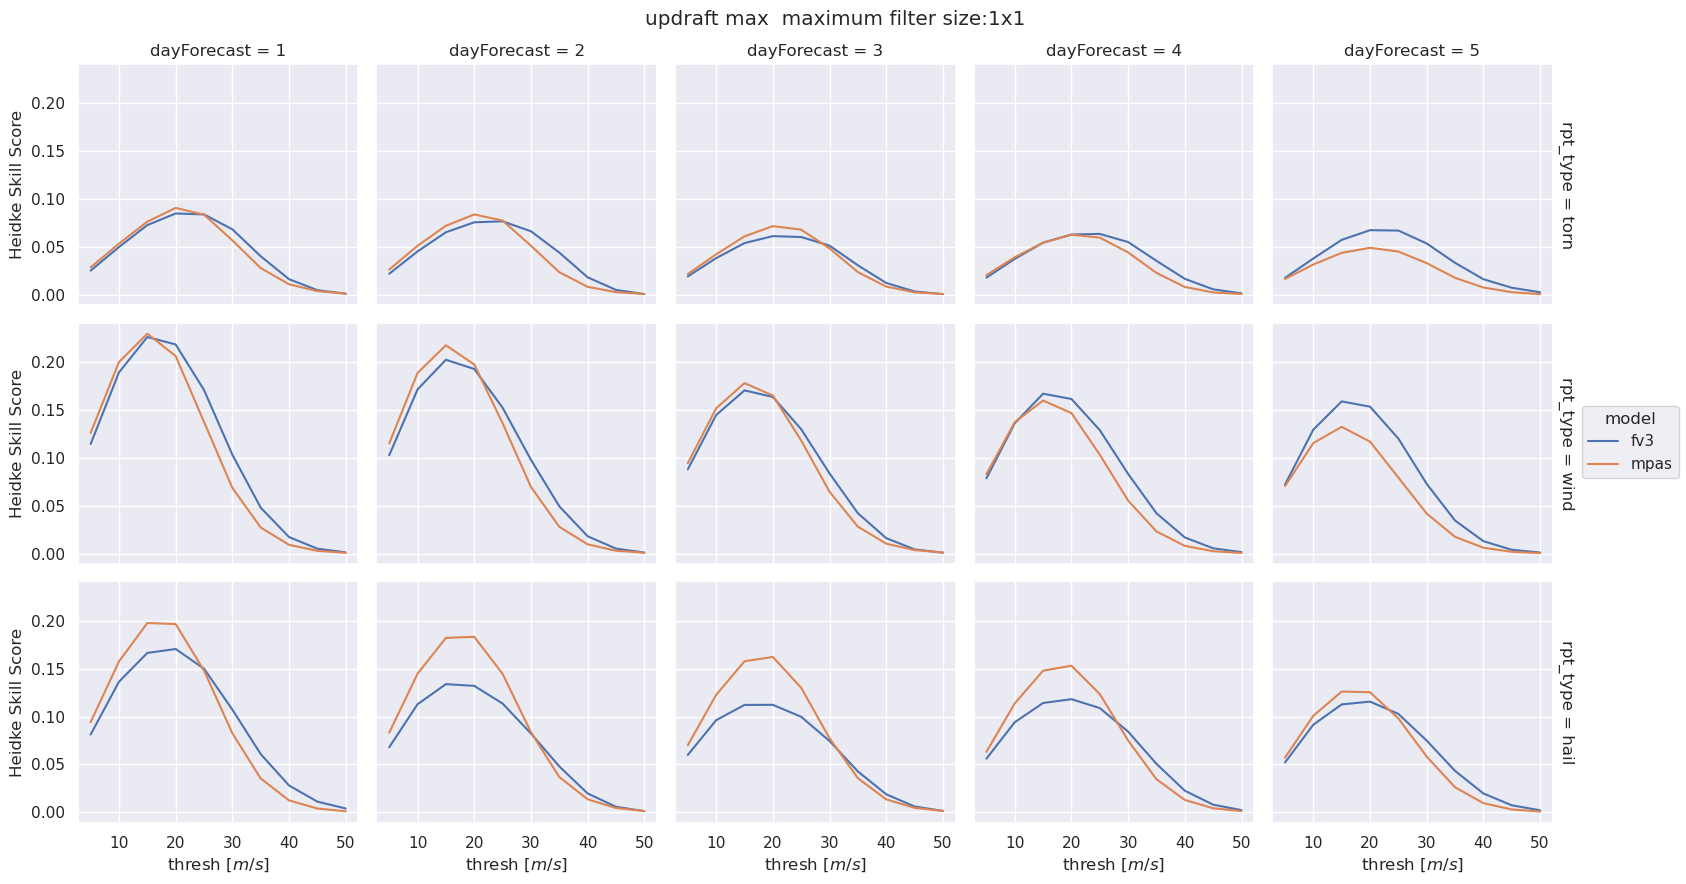

In [6]:
variable = genericnames[0]
s = contingency_table
# s = s.where(s.valid_date > pd.to_datetime("20240101")) # just one year
s = s.where(s.dayForecast <= 5, drop=True)  # just dayForecast 1-5
s = s.mean(dim="valid_date")
s = s.sel(variable=variable)
s = hss(s)
g = s.plot(col="dayForecast", row="rpt_type", hue="model")
g.fig.suptitle(f"{variable}  maximum filter size:{filter_size}x{filter_size}")
ofile = f"results.{variable}.{filter_size}x{filter_size}.png"
g.fig.subplots_adjust(top=0.92)
g.fig.savefig(ofile, dpi=150)
logging.warning(ofile)

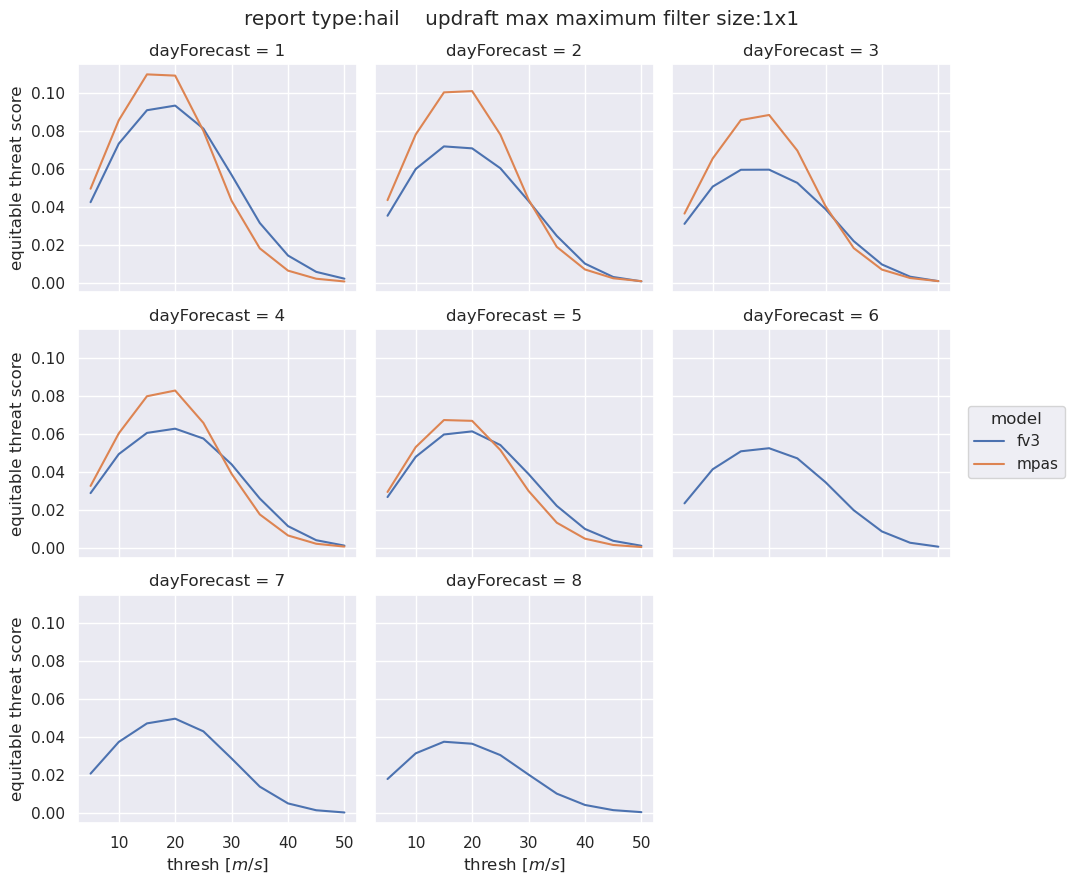

In [53]:
rpt_type = "hail"
s = ets(contingency_table.sum(dim="valid_date"))
g = s.sel(variable=variable, rpt_type=rpt_type).plot(col="dayForecast", hue="model", col_wrap=3)
g.fig.suptitle(
    f"report type:{rpt_type}    {variable} maximum filter size:{filter_size}x{filter_size}"
)
g.fig.subplots_adjust(top=0.92)

### Aggregate dayForecasts

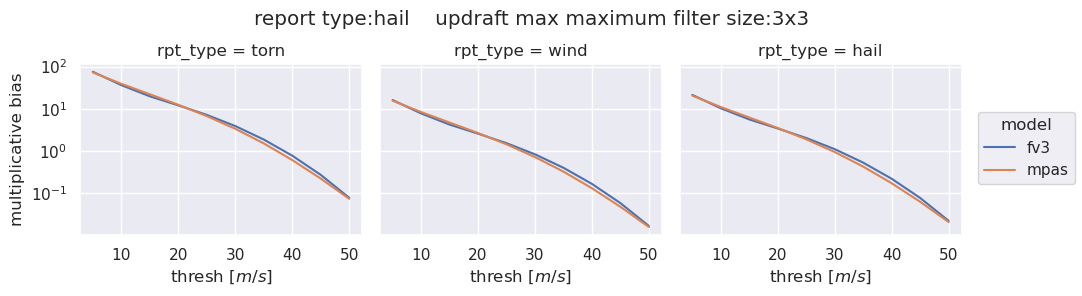

In [44]:
s = bias(contingency_table.sum(dim="valid_date").sum(dim="dayForecast"))
g = s.sel(variable=variable).plot(col="rpt_type", hue="model", yscale="log")
g.fig.suptitle(
    f"report type:{rpt_type}    {variable} maximum filter size:{filter_size}x{filter_size}"
)
g.fig.subplots_adjust(top=0.8)

AttributeError: 'function' object has no attribute 'axhline'

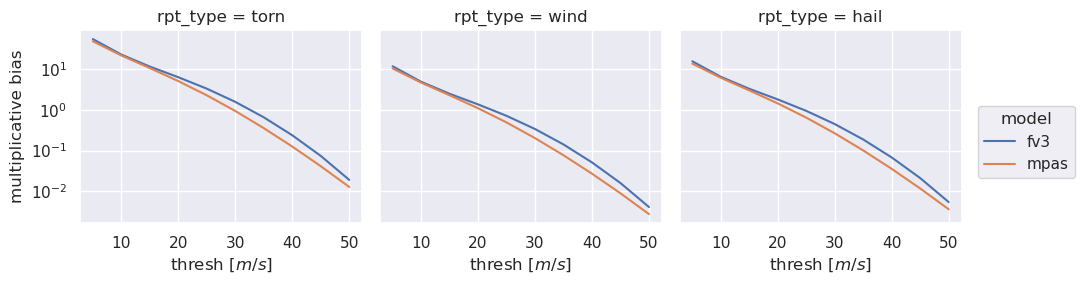

In [56]:
s = bias(contingency_table.sum(dim="valid_date").sum(dim="dayForecast"))
g = s.sel(variable=variable).plot(col="rpt_type", hue="model", yscale="log")
g.map(plt.axes.axhline(y=1))
g.fig.suptitle(
    f"report type:{rpt_type}    {variable} maximum filter size:{filter_size}x{filter_size}"
)
g.fig.subplots_adjust(top=0.8)

In [38]:
def performance_diagram(color=None, label=None):
    """
    performace diagram
    xaxis = 1-far
    yaxis = prob of detection
    where far = fp / (tp+fp)
    """
    ax = plt.gca()
    bias_lines = [0.2, 0.5, 0.8, 1, 1.3, 2, 5]
    csi_lines = np.arange(0.1, 1.0, 0.1)
    alpha = 0.8
    lw = 1
    color="0.8"
    bias_pts = [
        [sr * b for sr in [0, 1.0]] for b in bias_lines
    ]  # compute pod values for each bias line
    csi_pts = np.array(
        [
            [csi / (csi - (csi / sr) + 1) for sr in np.arange(0.011, 1.01, 0.005)]
            for csi in csi_lines
        ]
    )  # compute pod values for each csi line
    csi_pts = np.ma.masked_array(csi_pts, mask=(csi_pts < 0.05))

    # add bias and CSI lines to performance diagram
    for r in bias_pts:
        ax.plot([0, 1], r, color=color, linestyle="dashed", lw=lw, alpha=alpha)
    for r in csi_pts:
        ax.plot(
            np.arange(0.01, 1.01, 0.005),
            r,
            color=color,
            alpha=alpha,
            linestyle="solid",
            linewidth=lw,
        )
    for x in [b for b in bias_lines if b <= 1]:
        ax.text(1.002, x, x, va="center", ha="left", fontsize="x-small", color="0.5")
    for x in [b for b in bias_lines if b > 1]:
        ax.text(1 / x, 1, x, va="baseline", ha="center", fontsize="xx-small", color="0.5")

    # axes limits, labels
    ax.set_xlim((0, 1))
    ax.set_ylim((0, 1))
    return ax

In [39]:
x = 1-far(contingency_table.sum(dim="valid_date"))
x.name="1-far"
y = pod(contingency_table.sum(dim="valid_date"))
data = xarray.merge([x, y], compat='override')
data = data.sel(variable=variable).to_dataframe().drop(columns="count").reset_index(drop=False)
data

,dayForecast,thresh,rpt_type,model,variable,1-far,probability of detection
0,1,5,torn,fv3,updraft max,0.013838,0.852884
1,1,5,torn,mpas,updraft max,0.013926,0.914115
2,1,5,wind,fv3,updraft max,0.065755,0.860131
3,1,5,wind,mpas,updraft max,0.065214,0.908552
4,1,5,hail,fv3,updraft max,0.047787,0.811509
...,...,...,...,...,...,...,...
475,8,50,torn,mpas,updraft max,NaN,NaN
476,8,50,wind,fv3,updraft max,0.114810,0.001395
477,8,50,wind,mpas,updraft max,NaN,NaN
478,8,50,hail,fv3,updraft max,0.140983,0.002304


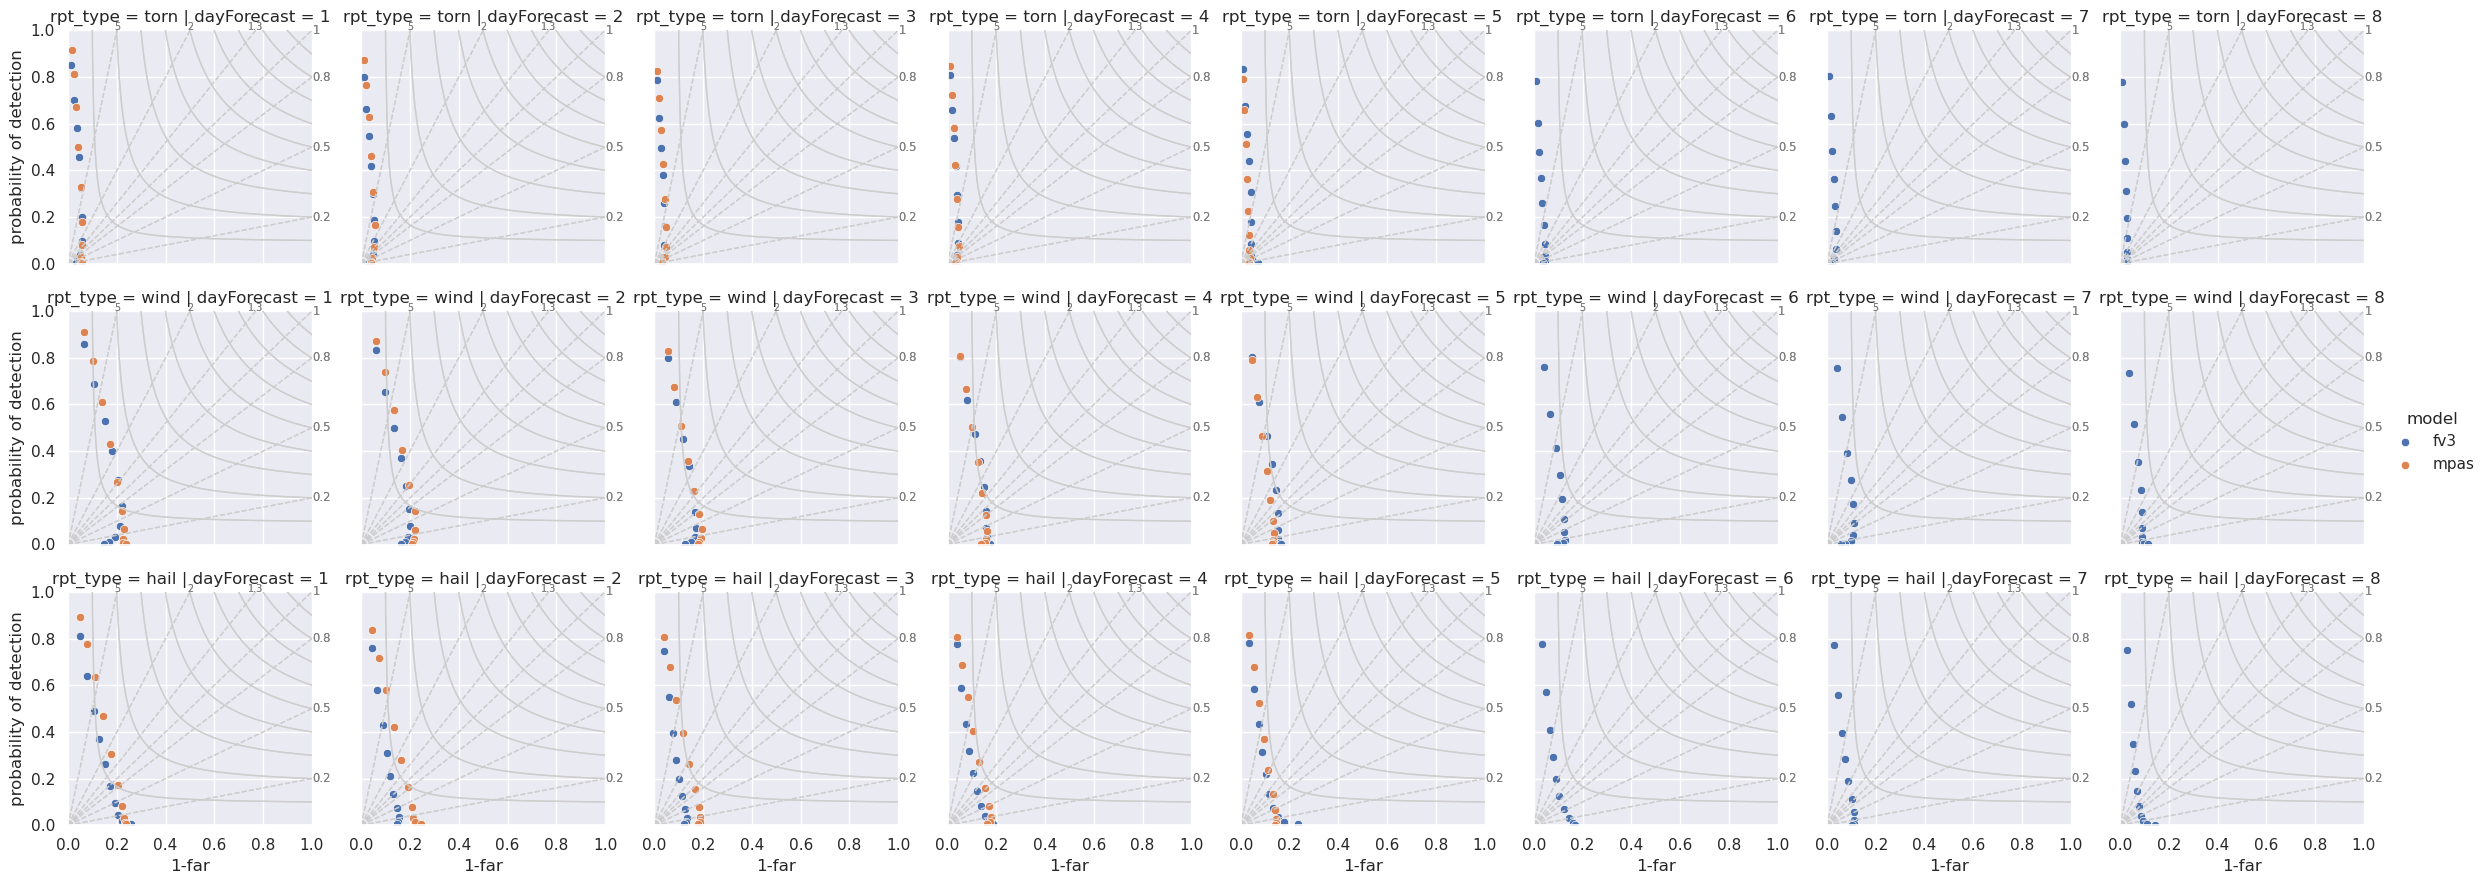

In [40]:
g = sns.FacetGrid(data, col="dayForecast", row="rpt_type", hue="model")
g.map(performance_diagram)
g.map(sns.scatterplot, "1-far", "probability of detection")
g.add_legend()

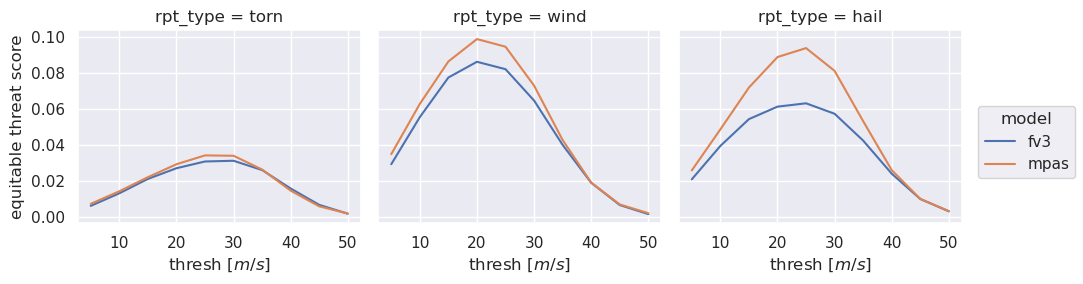

In [45]:
s = ets(contingency_table.sum(dim="dayForecast").sum(dim="valid_date"))
g = s.sel(variable=variable).plot(col="rpt_type", hue="model")

## Calculate climatology
- Used in run_ct method above

In [12]:
O = contingency_table.sel(count="hits") + contingency_table.sel(count="misses")
climo = O / total(contingency_table)
# use first dayForecast cause it has more early dates
# use first of everything else because they are all the same
s = climo.sel(dayForecast=1).isel(thresh=0, variable=0, model=0).mean(dim="valid_date")
s

<xarray.DataArray 'ensmax' (rpt_type: 3)>
array([0.00636523, 0.03211523, 0.02110088])
Coordinates:
    dayForecast  int64 1
    thresh       int64 5
    variable     <U13 'updraft max'
  * rpt_type     (rpt_type) <U4 'torn' 'wind' 'hail'
    model        <U4 'fv3'

In [8]:
O = contingency_table.sel(count="hits") + contingency_table.sel(count="misses")
climo = O / total(contingency_table)
# use first dayForecast cause it has more early dates
# use first of everything else because they are all the same
s = climo.sel(dayForecast=1).isel(thresh=0, variable=0, model=0).mean(dim="valid_date")
s

<xarray.DataArray 'ensmax' (rpt_type: 3)>
array([0.00636523, 0.03211523, 0.02110088])
Coordinates:
    dayForecast  int64 1
    thresh       int64 5
    variable     <U13 'updraft max'
  * rpt_type     (rpt_type) <U4 'torn' 'wind' 'hail'
    model        <U4 'fv3'

In [78]:
O = contingency_table.sel(count="hits") + contingency_table.sel(count="misses")
climo = O / total(contingency_table)
# use first dayForecast cause it has more early dates
# use first of everything else because they are all the same
s = climo.sel(dayForecast=1).isel(thresh=0, variable=0, model=0).mean(dim="valid_date")
s

<xarray.DataArray 'ensmax' (rpt_type: 3)>
array([0.00394758, 0.01859965, 0.01432699])
Coordinates:
    dayForecast  int64 1
    thresh       int64 10
    variable     <U8 '0-1km UH'
  * rpt_type     (rpt_type) <U4 'torn' 'wind' 'hail'
    model        <U4 'fv3'

In [48]:
ifiles = list(datadir.glob("near_rpt.20??-??-?? ??:??:?[0-9].nc"))
print(len(ifiles))
near_rpts = xarray.open_mfdataset(ifiles, combine="nested", concat_dim="time")
# Keep near_rpts where conus_mask is True; otherwise set to nan.
# nans will propagate to h, m, f, and n and not be counted when the .sum() function
# is used below.
near_rpts = near_rpts.where(conus_mask)
((near_rpts == 1).sum(dim=["lon","lat","time"])/(near_rpts == 0).sum(dim=["lon","lat","time"])).compute()

80


<xarray.Dataset>
Dimensions:    (rpt_type: 3)
Coordinates:
  * rpt_type   (rpt_type) <U4 'torn' 'wind' 'hail'
Data variables:
    near_rpts  (rpt_type) float64 0.003963 0.01895 0.01454